# Добро пожаловать во временные ряды! #

**Прогнозирование** — пожалуй, самое распространенное применение машинного обучения в реальном мире. Бизнес прогнозирует спрос на продукты, правительства прогнозируют экономический и демографический рост, метеорологи прогнозируют погоду. Понимание того, что нас ждет впереди, — насущная потребность в науке, государственном управлении и промышленности (не говоря уже о нашей личной жизни!), и специалисты в этих областях все чаще применяют машинное обучение, чтобы справляться с этой задачей.

Прогнозирование временных рядов — широкая область с долгой историей. Этот курс сосредоточен на применении современных методов машинного обучения к данным временных рядов, чтобы получать максимально точные прогнозы. Уроки в этом курсе вдохновлены победными решениями прошлых соревнований по прогнозированию на Kaggle, но будут полезны всякий раз, когда точность прогнозов — приоритет.

После прохождения курса вы сможете:
- конструировать признаки для моделирования основных компонентов временного ряда (*трендов*, *сезонностей* и *циклов*),
- визуализировать временные ряды с помощью разных видов *графиков временных рядов*,
- создавать прогнозные *гибриды*, объединяющие сильные стороны дополняющих друг друга моделей, и
- адаптировать методы машинного обучения под различные задачи прогнозирования.

В рамках упражнений у вас будет возможность поучаствовать в нашем соревновании для начинающих [Store Sales - Time Series Forecasting](https://www.kaggle.com/c/29781). В этом соревновании вам нужно прогнозировать продажи для *Corporación Favorita* (крупного продуктового ритейлера из Эквадора) почти по 1800 категориям товаров.

# Что такое временной ряд? #

Основной объект прогнозирования — **временной ряд**, то есть набор наблюдений, записанных во времени. В задачах прогнозирования наблюдения обычно фиксируются с регулярной частотой, например ежедневно или ежемесячно.


In [1]:

import pandas as pd

df = pd.read_csv(
    "../dataset/book_sales.csv",
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)

df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


Этот ряд отражает количество продаж книг в твердом переплете в розничном магазине за 30 дней. Обратите внимание, что у нас один столбец наблюдений `Hardcover` с временным индексом `Date`.

# Линейная регрессия и временные ряды #

В первой части курса мы будем использовать алгоритм линейной регрессии для построения прогнозных моделей. Линейная регрессия широко применяется на практике и естественно адаптируется даже к сложным задачам прогнозирования.

Алгоритм **линейной регрессии** учится делать взвешенную сумму входных признаков. Для двух признаков это будет:

```
target = weight_1 * feature_1 + weight_2 * feature_2 + bias
```

Во время обучения алгоритм регрессии подбирает значения параметров `weight_1`, `weight_2` и `bias`, которые лучше всего описывают `target`. (Этот алгоритм часто называют *методом наименьших квадратов*, поскольку он выбирает значения, минимизирующие квадратичную ошибку между целевыми значениями и предсказаниями.) Веса также называют *регрессионными коэффициентами*, а `bias` называют *свободным членом* или *интерсептом*, потому что он показывает, где график этой функции пересекает ось y.

### Признаки временного шага

Есть два типа признаков, характерных для временных рядов: признаки временного шага и лаговые признаки.

Признаки временного шага — это признаки, которые мы можем получить напрямую из временного индекса. Самый базовый признак временного шага — **временная фиктивная переменная**, которая просто нумерует шаги ряда от начала до конца.


In [2]:

import numpy as np

df['Time'] = np.arange(len(df.index))

df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


Линейная регрессия с временной фиктивной переменной дает модель:

```
target = weight * time + bias
```

Временная фиктивная переменная позволяет нам аппроксимировать кривые на *временном графике*, где `Time` образует ось x.


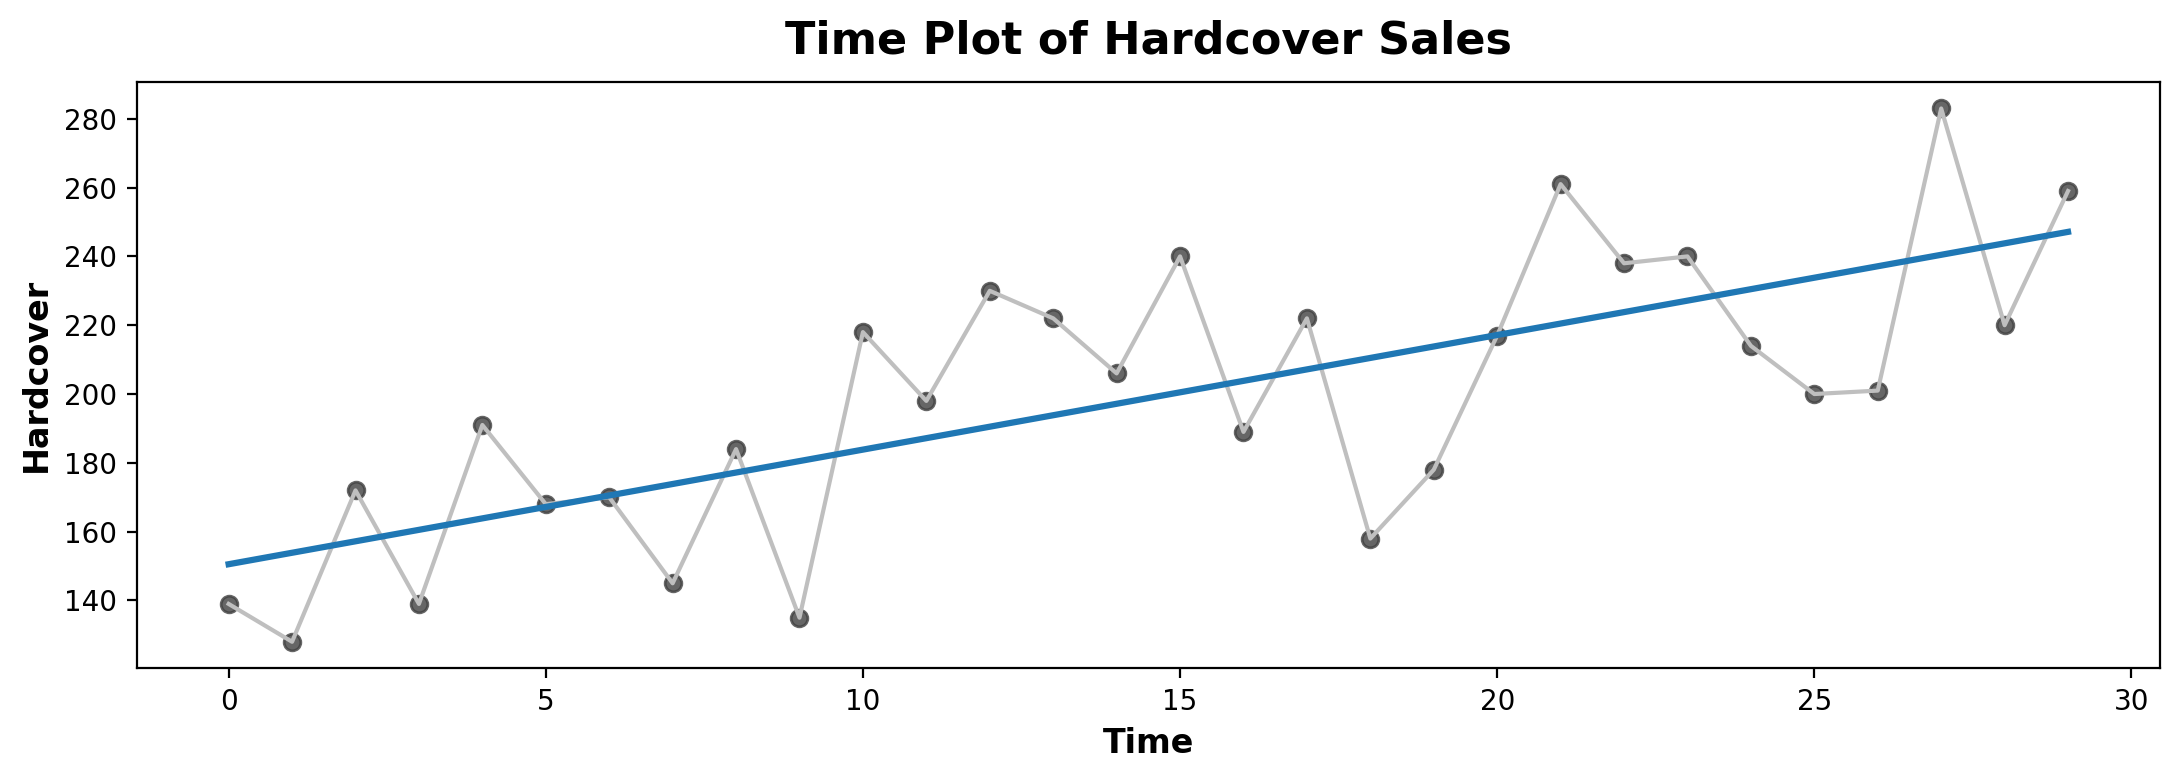

In [3]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

Признаки временного шага позволяют моделировать **временную зависимость**. Ряд является временно зависимым, если его значения можно предсказать по времени, когда они были получены. В ряду *Hardcover Sales* мы можем предсказать, что продажи ближе к концу месяца, как правило, выше, чем в начале месяца.

### Лаговые признаки

Чтобы получить **лаговый признак**, мы сдвигаем наблюдения целевого ряда так, будто они произошли позже во времени. Здесь мы создали лаг на 1 шаг, хотя можно сдвигать и на несколько шагов.


In [4]:

df['Lag_1'] = df['Hardcover'].shift(1)
df = df.reindex(columns=['Hardcover', 'Lag_1'])

df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


Линейная регрессия с лаговым признаком дает модель:

```
target = weight * lag + bias
```

Таким образом, лаговые признаки позволяют нам подбирать кривые на *лаговых графиках*, где каждое наблюдение в ряду откладывается относительно предыдущего наблюдения.


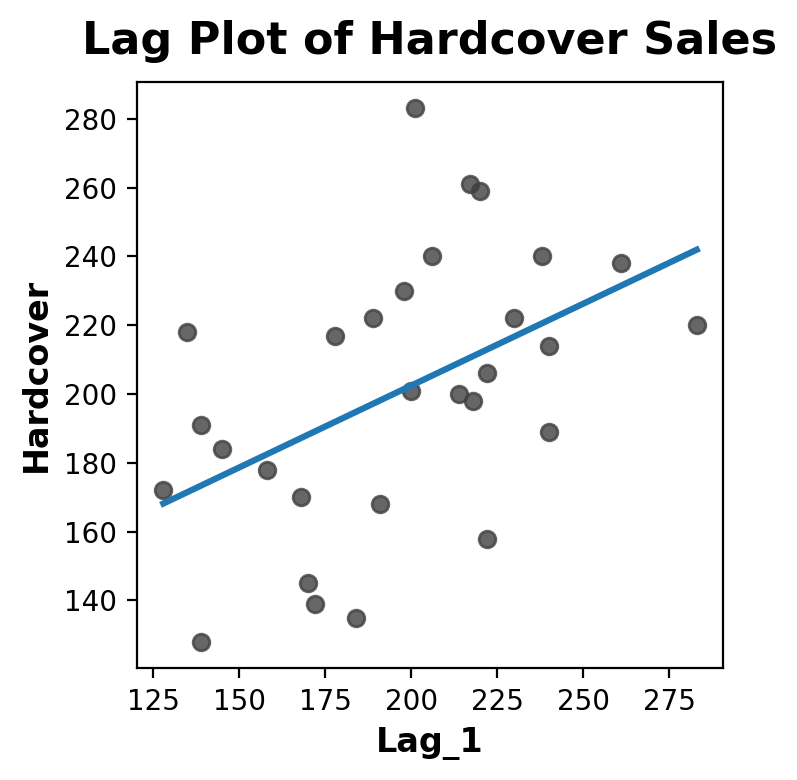

In [5]:

fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

По лаговому графику видно, что продажи в один день (`Hardcover`) коррелируют с продажами предыдущего дня (`Lag_1`). Когда вы видите такую связь, понятно, что лаговый признак будет полезен.

В более общем смысле лаговые признаки позволяют моделировать **серийную зависимость**. Временной ряд имеет серийную зависимость, когда наблюдение можно предсказать по предыдущим наблюдениям. В *Hardcover Sales* мы можем предсказать, что высокие продажи в один день обычно означают высокие продажи на следующий день.

---

Адаптация алгоритмов машинного обучения к задачам временных рядов во многом сводится к созданию признаков из временного индекса и лагов. В большей части курса мы используем линейную регрессию из-за ее простоты, но эти признаки будут полезны независимо от того, какой алгоритм вы выберете для своей задачи прогнозирования.

# Пример — Трафик в туннеле #

*Tunnel Traffic* — это временной ряд, описывающий количество транспортных средств, проезжающих через туннель Барегг в Швейцарии каждый день с ноября 2003 по ноябрь 2005. В этом примере мы попрактикуемся применять линейную регрессию к признакам временного шага и лаговым признакам.

Скрытая ячейка все подготовит.


In [6]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
data_dir = Path("../dataset/")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])

# Create a time series in Pandas by setting the index to a date
# column. We parsed "Day" as a date type by using `parse_dates` when
# loading the data.
tunnel = tunnel.set_index("Day")

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel = tunnel.to_period()

tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


### Признак временного шага

При условии, что во временном ряду нет пропущенных дат, мы можем создать временную фиктивную переменную, просто пронумеровав длину ряда.


In [7]:
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


Процедура обучения модели линейной регрессии следует стандартным шагам для scikit-learn.


In [8]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

Фактически созданная модель (приблизительно): `Vehicles = 22.5 * Time + 98176`. График подогнанных значений во времени показывает, как линейная регрессия по временной фиктивной переменной создает линию тренда, заданную этим уравнением.


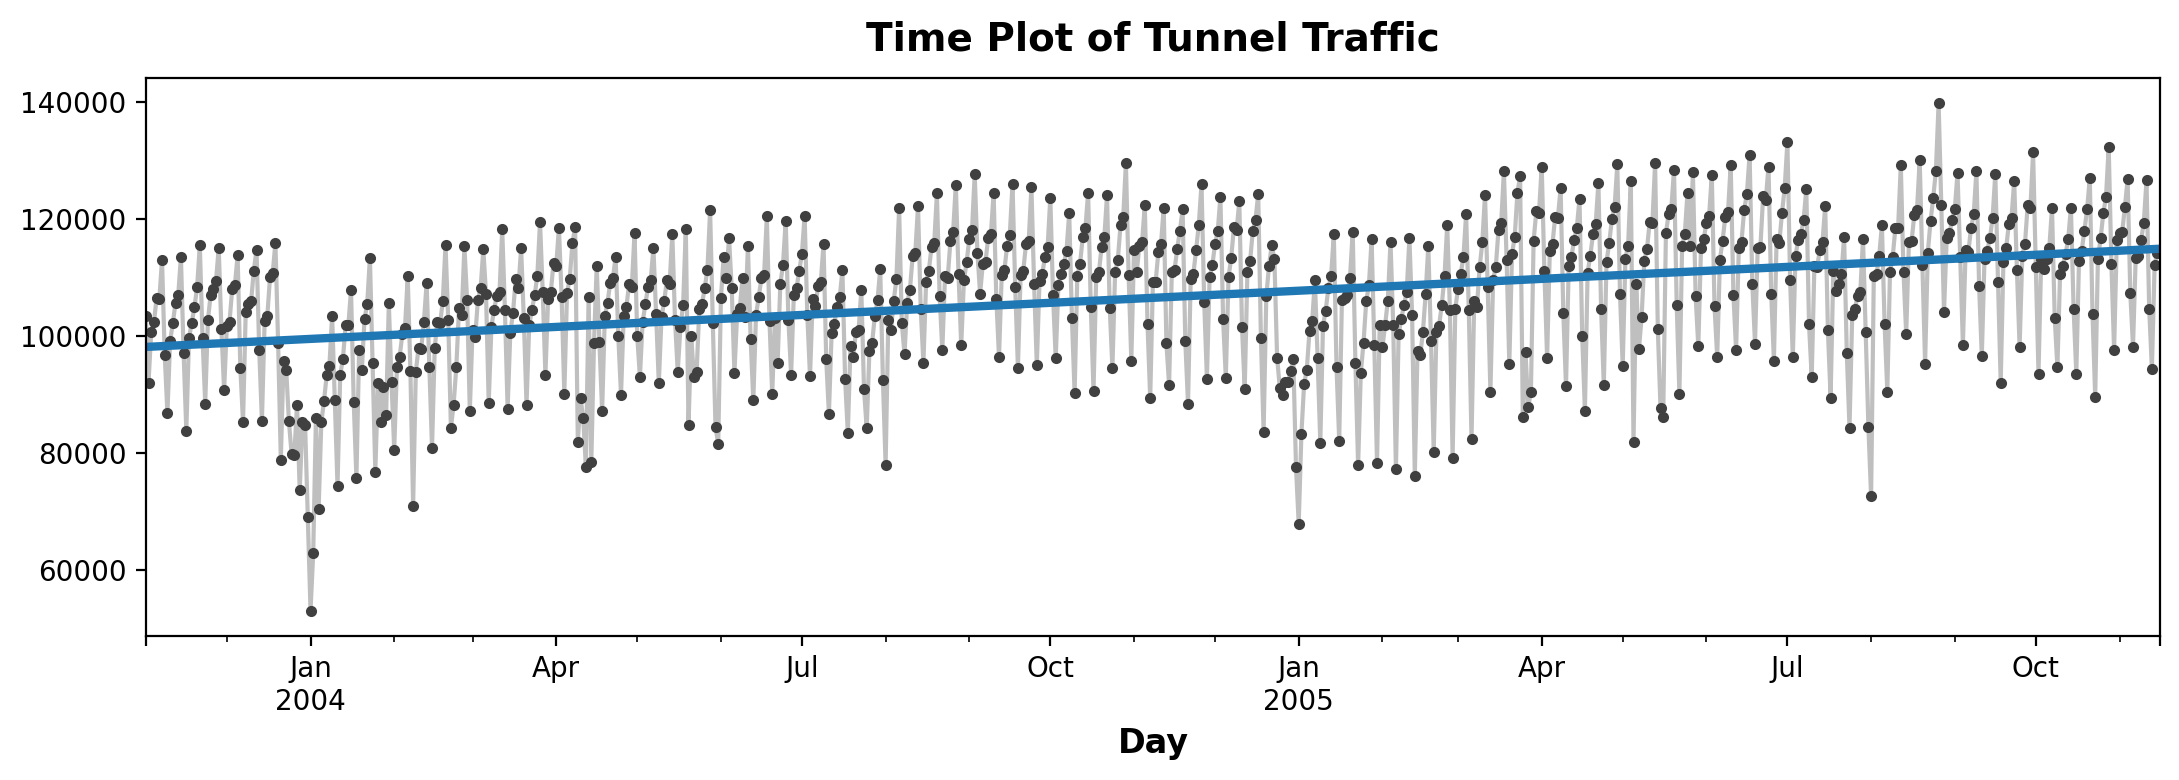

In [9]:

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

### Лаговый признак

Pandas предоставляет простой метод для сдвига ряда — `shift`.


In [10]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


При создании лаговых признаков нужно решить, что делать с появляющимися пропущенными значениями. Один вариант — заполнить их, например 0.0, или сделать «обратное заполнение» первым известным значением. Вместо этого мы просто удалим пропуски, следя за тем, чтобы также удалить соответствующие даты из целевой переменной.


In [13]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'NumVehicles']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

Лаговый график показывает, насколько хорошо мы смогли подогнать связь между количеством транспортных средств в один день и количеством в предыдущий день.


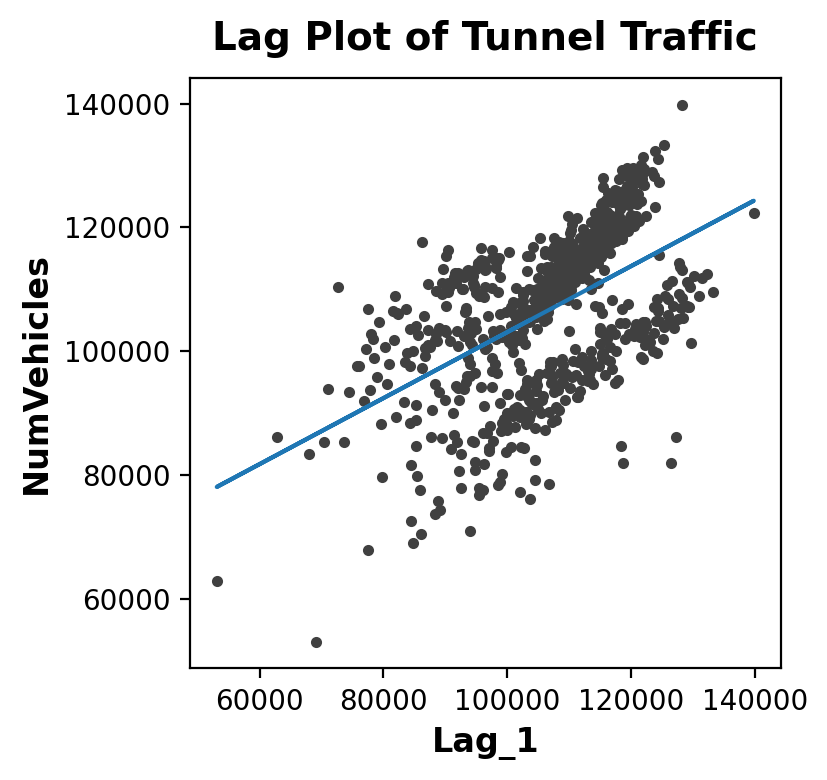

In [14]:

fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

Что означает это предсказание на основе лагового признака для того, насколько хорошо мы можем прогнозировать ряд во времени? Следующий временной график показывает, как наши прогнозы теперь реагируют на поведение ряда в недавнем прошлом.


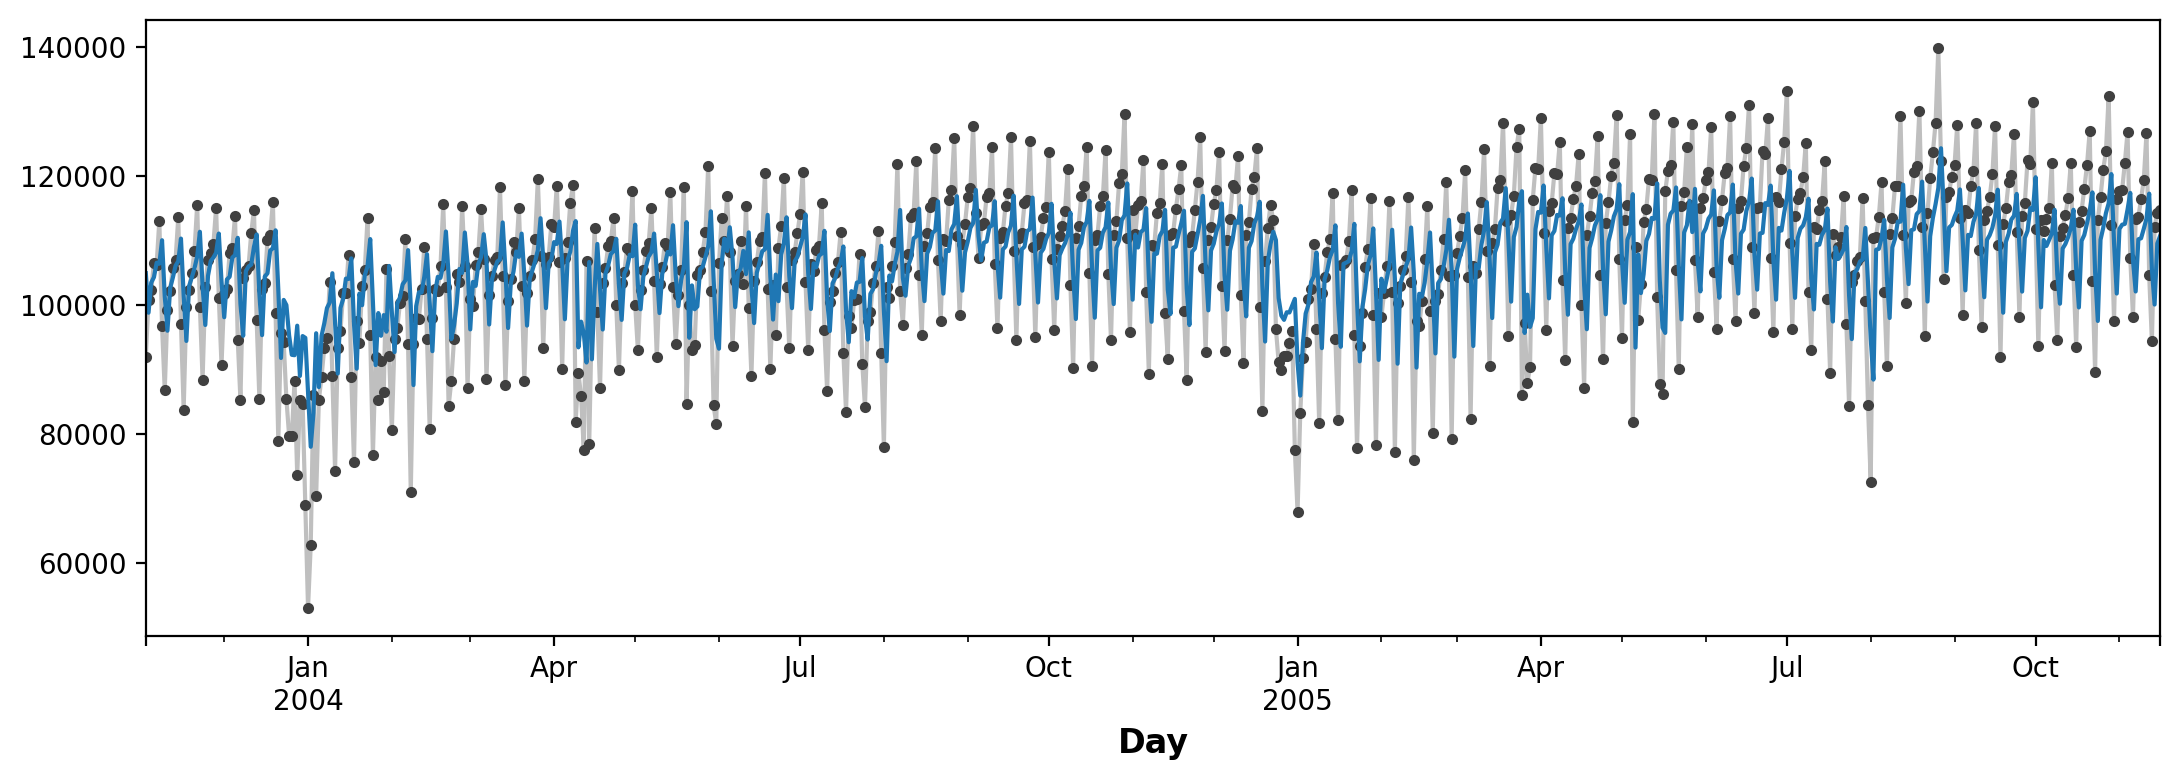

In [15]:

ax = y.plot(**plot_params)
ax = y_pred.plot()

Лучшие модели временных рядов обычно включают некоторую комбинацию признаков временного шага и лаговых признаков. В следующих нескольких уроках мы научимся конструировать признаки, моделирующие наиболее распространенные шаблоны во временных рядах, используя признаки из этого урока как отправную точку.

# Теперь ваша очередь #

Переходите к упражнению, где вы начнете [**прогнозировать Store Sales**](https://www.kaggle.com/kernels/fork/19615998), используя техники, изученные в этом туториале.


---



*Есть вопросы или комментарии? Посетите [форум обсуждения курса](https://www.kaggle.com/learn/time-series/discussion), чтобы пообщаться с другими учащимися.*
